# Stock Proce Prediction 股價預測 II
> 利用 Facebook 的數據預測工具 Prophet 預測未來股價

- toc: false 
- badges: true
- comments: false
- sticky_rank: 2
- author: ChiHong Lin 
- categories: [python, prediction, jupyter, facebook prophet, Stock Price]


2017年，Facebook 宣佈開源一款基於 Python 和 R 語言的數據預測工具——「Prophet」，即「先知」。取名倒是非常直白。

Facebook 表示，Prophet 相比現有預測工具更加人性化，並且難得地提供 Python 支援。另外，它生成的預測結果足以和專業數據分析師媲美 。

今天，我們嘗試利用 Prophet 這個數據預測模型，來預測股價的未來走向

## Facebook Prophet Model

從 Facebook 官方聲明來看， 推出 Prophet，是希望用它來替代 forecast，成為最受歡迎的預測工具 。相對於後者，Facebook 表示 Prophet 有兩大優點：

### 一、開發合理、準確的預測模型更加直接。
之前許多預測工具 ARIMA 和 exponential smoothing 等等，每一項工具都有它的長處、短處和調節參數。但 Facebook 表示，選擇不恰當的模型或參數會造成讓人難以滿意的結果；而即便是有經驗的數據分析師在選擇模型、參數上也經常遇到困難。言下之意是，Prophet 將著重改善這方面的體驗，讓模型、參數的選擇更直觀。

### 二、用 Prophet 做出的預測，能夠以對普通人更加直觀的方式進行定制。
Prophet 有針對週期性的平滑參數（smoothing parameters for seasonality），允許開發者調整與歷史週期的匹配程度。它還有針對趨勢的平滑參數，能夠調整對歷史趨勢變化的緊跟程度。對於成長曲線（growth curves），開發者能人工設置上限，即 capacities，把關於「該預測如何成長（或下降）」的先驗訊息注入進去。最後，開發者還能設置不規則日期，來對超級杯、感恩節、黑色星期五之類的特殊日子進行建模。

Facebook 把預測任務的流程用下圖展示出來：

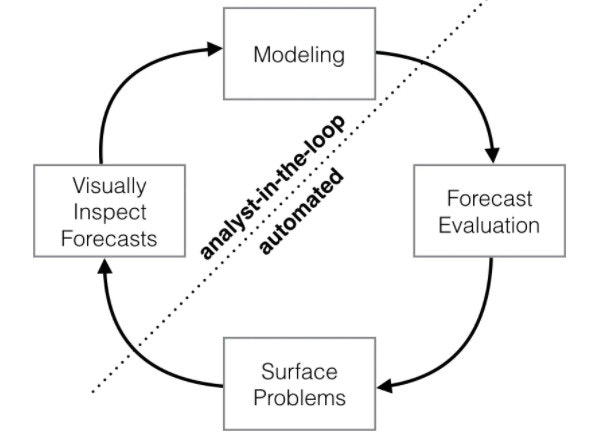

從圖中可以看出，預測共分四個流程：建模，預測評估，表面問題和人工檢查。

### 組成部分

Prophet 的核心是一個可加性迴歸模型（additive regression model），它有四個組成部分：

- 一個分段的線性或邏輯成長曲線趨勢。Prophet 通過提取數據中的轉變點，自動檢測趨勢變化。
- 一個按年的週期組件，使用傅立葉級數（Fourier series）建模而成。
- 一個按周的週期組件，使用虛擬變量（dummy variables）。
- 使用者設置的重要節日表。

### 適用範圍

Prophet 針對的是商業預測任務，適用於具備以下特徵的場景：

- 針對每小時、每天或每星期的觀察，有至少數月（理想情況的一年）的歷史記錄。
- 多重顯著的「人類層級」週期性：星期 X 以及年份。
- 日期間隔不規則的重要節日（比如超級杯），需要事先得知。
- 觀察缺失或是異常值在合理範圍內。
- 歷史趨勢變化，比如產品發佈或者改寫記錄（logging changes）。
- 符合非線性成長曲線的趨勢，有天然上、下限或者飽和點。

## 開始進行價格預測

### 資料來源

在這次的練習中，我透過 [yahoo finance](https://finance.yahoo.com/quote/TSLA/history?p=TSLA) 來取得特斯拉（代號： TSLA）的歷史股價並下載為CSV格式檔案：

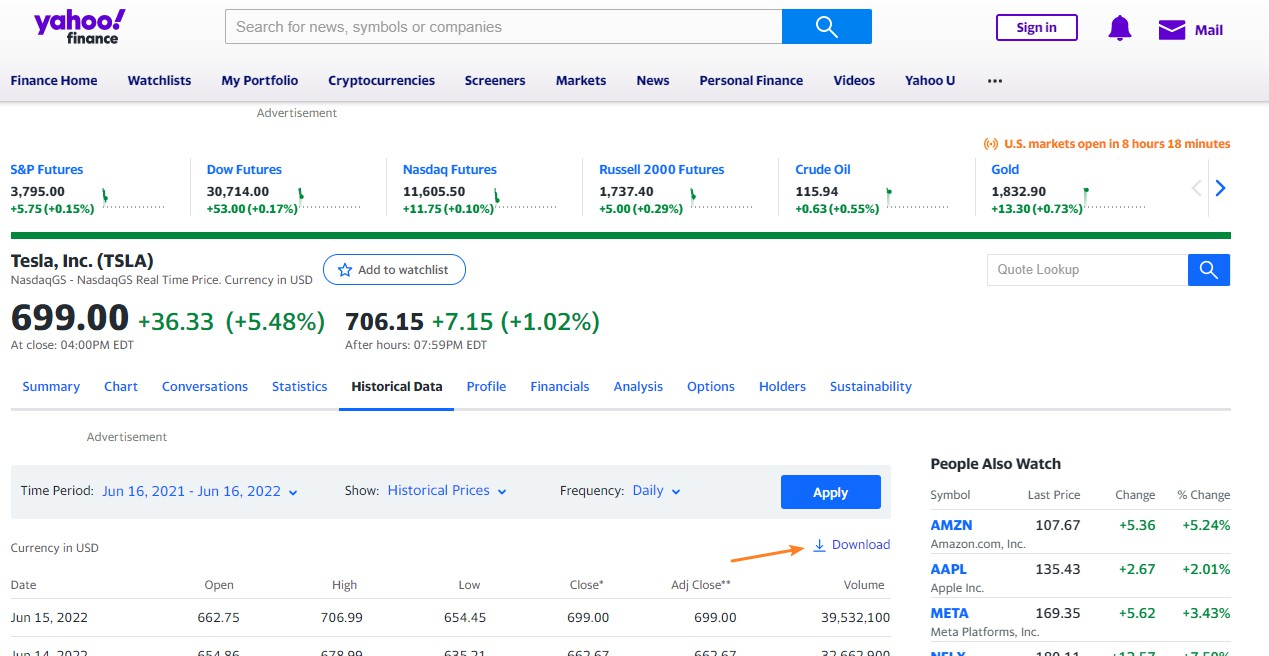

載入相關的函式庫以歷史股價資料

In [1]:
# !pip install fbprophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

data = pd.read_csv("https://github.com/impepper/myPortfolio/raw/master/_notebooks/datasource/TSLA.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-06-14,612.229980,625.489990,609.179993,617.690002,617.690002,20424000
1,2021-06-15,616.690002,616.789978,598.229980,599.359985,599.359985,17764100
2,2021-06-16,597.539978,608.500000,593.500000,604.869995,604.869995,22144100
3,2021-06-17,601.890015,621.469971,601.340027,616.599976,616.599976,22701400
4,2021-06-18,613.369995,628.349976,611.799988,623.309998,623.309998,24560900


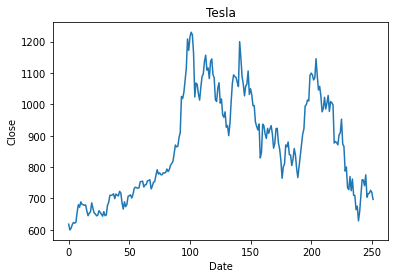

In [2]:
close = data['Close']
ax = close.plot(title='Tesla')
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.show()

由於Prophet數據預測僅需要時間序列（日期）以及價格資訊，我們僅留下日期以及收盤價兩個欄位資料，並且依照Prophet的欄位格式，將其更名為ds`（日期）及y（收盤價）：

In [3]:
data["Date"] = pd.to_datetime(data["Date"], infer_datetime_format=True)
data = data[["Date", "Close"]]

data = data.rename(columns={"Date" : "ds", "Close" : "y" })

有了這兩個數據，我們就可以透過 Prophet 進行預測：

In [4]:
model = Prophet(daily_seasonality = True)
model.fit(data)
predict = model.make_future_dataframe(periods=365)  # 我們透過 Prophet 來預測未來 365 天的股價
forcast = model.predict(predict)
forcast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
612,2023-06-06,123.105231,-346.557206,577.605426
613,2023-06-07,123.295644,-321.961823,579.333774
614,2023-06-08,114.798291,-332.610815,584.606105
615,2023-06-09,107.121738,-367.662476,576.998907
616,2023-06-10,119.452811,-348.412252,564.446602


在預測的數據中，我們注意到預測價格包含了上限（預測的當日股價可能最大值）及下限（預測的當日股價可能最小值）
我們利用 matplot 函式庫，透過圖像的方式將其呈現出來：

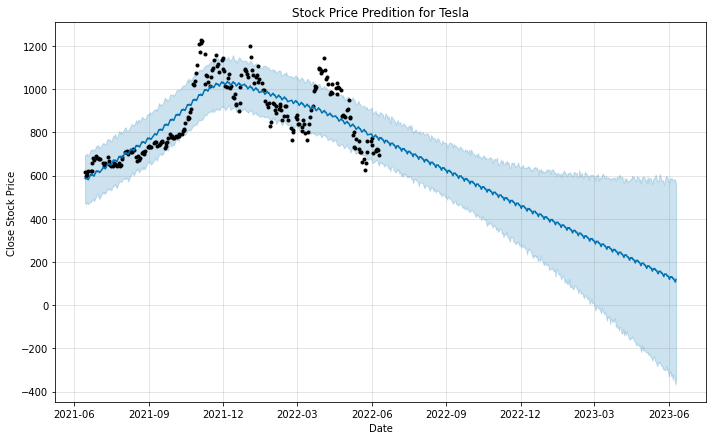

In [7]:
graph = model.plot(forcast, xlabel="Date", ylabel="Price")
plt.title("Stock Price Predition for Tesla")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

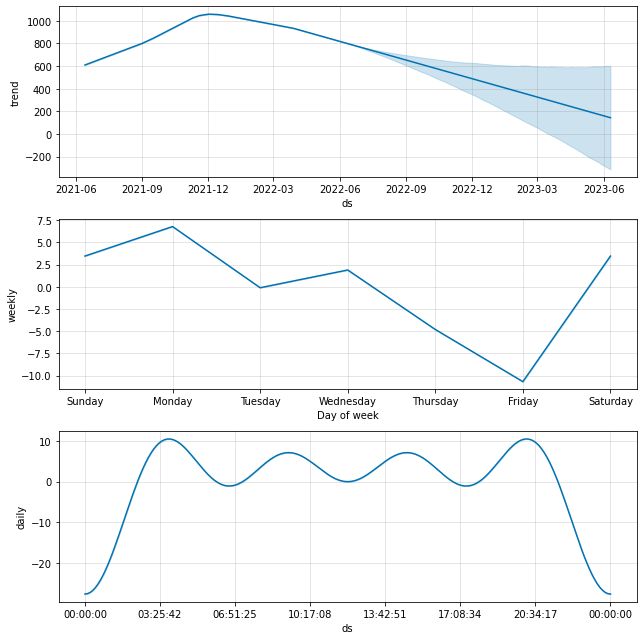

In [8]:
model.plot_components(forcast)
plt.show()

## 結論

從 Prophet 的預測結果來看，特斯拉的股價在未來，應是呈現一個下跌趨勢。至於特斯拉的未來股價，就有待日後證明。

我希望你喜歡這篇文章。 關於 Prophet 的更多細節，你可以參考以下連結：

使用指南：https://facebookincubator.github.io/prophet/docs/quick_start.html

檔案：http://facebookincubator.github.io/prophet/
